In [252]:
import pandas as pd
import glob
import os
import json
import numpy as np
import inspect
import sys
import math

In [187]:
# taking nominations from all waves
path = r'../data/movez_nominations' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))
df_nom = pd.concat((pd.read_csv(f,sep=';', header=0) for f in all_files), ignore_index=True)
df_nom

,Child,Wave,Variable,Alter
0,1420,7,GEN_Advice,1422
1,1420,7,GEN_Leader,1429
2,1421,7,GEN_Advice,1428
3,1421,7,GEN_Leader,1425
4,1421,7,GEN_Leader,1429
...,...,...,...,...
199932,2932,3,Di_Modelling_reversed,2927
199933,2932,3,Di_Modelling_reversed,2934
199934,2932,3,Di_Modelling_reversed,2936
199935,2932,3,Di_Modelling_reversed,2938


In [188]:
#keep only the GEN nominations
df_nom = df_nom[df_nom.Variable.str.startswith('GEN')]
df_nom.shape

(123859, 4)

##### First remove the 'extra' Alter children - who didn't gave consent and were thus not participants

In [189]:
lst_participants = list(set(df_nom['Child'].unique()).intersection(set(df_nom['Alter'].unique())))
len(lst_participants)

1467

In [190]:
df_nom = df_nom[(df_nom.Child.isin(lst_participants)) & (df_nom.Alter.isin(lst_participants)) ]

In [191]:
df_nom['Variable'].nunique(),df_nom['Child'].nunique(),df_nom['Alter'].nunique()

(6, 1457, 1466)

In [192]:
df_pp = pd.read_csv('../data/movez_metadata/Participant_Info.csv', sep=';', header=0)
df_pp.shape

(1484, 19)

In [193]:
df_pp = df_pp[(df_pp.Child.isin(lst_participants))]
df_pp.shape

(1467, 19)

In [194]:
df_pp.head(3)

,School,Level,Class_Y1,Class_Y2,Class_Y3,Child,Sex,Sex_f,Age_W1,Age_W5,W1,W2,W3,W4,W5,W6,W7,Y1_Sample,Y3_Sample
1,22,Secondary,52.0,52.0,NaN,904,1,Female,12.0,NaN,1,1,0,0,0,0,0,1,0
2,22,Secondary,52.0,52.0,NaN,907,1,Female,12.0,NaN,1,1,0,0,0,0,0,1,0
3,22,Secondary,52.0,55.0,NaN,908,0,Male,12.0,NaN,1,1,0,1,0,0,0,1,0


In [195]:
# New variables summing the number of participants per class and school
df_pp['num_per_school'] = df_pp.School.map(df_pp.groupby(['School'])['Level'].count())
df_pp['num_per_class_Y1'] = df_pp.Class_Y1.map(df_pp.groupby(['Class_Y1'])['Level'].count())
df_pp['num_per_class_Y2'] = df_pp.Class_Y2.map(df_pp.groupby(['Class_Y2'])['Level'].count())
df_pp['num_per_class_Y3'] = df_pp.Class_Y3.map(df_pp.groupby(['Class_Y3'])['Level'].count())

In [196]:
df_pp.head(10)

,School,Level,Class_Y1,Class_Y2,Class_Y3,Child,Sex,Sex_f,Age_W1,Age_W5,...,W4,W5,W6,W7,Y1_Sample,Y3_Sample,num_per_school,num_per_class_Y1,num_per_class_Y2,num_per_class_Y3
1,22,Secondary,52.0,52.0,NaN,904,1,Female,12.0,NaN,...,0,0,0,0,1,0,30,4.0,2.0,NaN
2,22,Secondary,52.0,52.0,NaN,907,1,Female,12.0,NaN,...,0,0,0,0,1,0,30,4.0,2.0,NaN
3,22,Secondary,52.0,55.0,NaN,908,0,Male,12.0,NaN,...,1,0,0,0,1,0,30,4.0,8.0,NaN
4,22,Secondary,52.0,55.0,NaN,909,0,Male,12.0,NaN,...,1,0,0,0,1,0,30,4.0,8.0,NaN
6,22,Secondary,54.0,54.0,NaN,935,0,Male,13.0,NaN,...,1,0,0,0,1,0,30,6.0,5.0,NaN
7,22,Secondary,54.0,54.0,NaN,936,0,Male,13.0,NaN,...,0,0,0,0,1,0,30,6.0,5.0,NaN
8,22,Secondary,54.0,NaN,NaN,942,1,Female,13.0,NaN,...,1,0,0,0,1,0,30,6.0,NaN,NaN
9,22,Secondary,54.0,54.0,NaN,944,0,Male,13.0,NaN,...,0,0,0,0,1,0,30,6.0,5.0,NaN
10,22,Secondary,54.0,54.0,NaN,947,1,Female,12.0,NaN,...,1,0,0,0,1,0,30,6.0,5.0,NaN
11,22,Secondary,54.0,55.0,NaN,949,0,Male,12.0,NaN,...,1,0,0,0,1,0,30,6.0,8.0,NaN


In [197]:
# mapping the necessary columns
df_nom['Child_School'] = df_nom['Child'].map(df_pp.set_index('Child')['School'])
df_nom['Child_School_Participants'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_school'])
df_nom['Child_Class_Y1'] = df_nom['Child'].map(df_pp.set_index('Child')['Class_Y1'])
df_nom['Child_Class_Y2'] = df_nom['Child'].map(df_pp.set_index('Child')['Class_Y2'])
df_nom['Child_Class_Y3'] = df_nom['Child'].map(df_pp.set_index('Child')['Class_Y3'])
df_nom['Child_num_per_class_Y1'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_nom['Child_num_per_class_Y2'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_nom['Child_num_per_class_Y3'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y3'])

df_nom['Alter_School'] = df_nom['Alter'].map(df_pp.set_index('Child')['School'])
df_nom['Alter_School_Participants'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_school'])
df_nom['Alter_Class_Y1'] = df_nom['Alter'].map(df_pp.set_index('Child')['Class_Y1'])
df_nom['Alter_Class_Y2'] = df_nom['Alter'].map(df_pp.set_index('Child')['Class_Y2'])
df_nom['Alter_Class_Y3'] = df_nom['Alter'].map(df_pp.set_index('Child')['Class_Y3'])
df_nom['Alter_num_per_class_Y1'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_nom['Alter_num_per_class_Y2'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_nom['Alter_num_per_class_Y3'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y3'])

df_nom['questions_per_wave'] = df_nom.Wave.map(df_nom.groupby(['Wave'])['Variable'].nunique())

df_nom.head(3)

,Child,Wave,Variable,Alter,Child_School,Child_School_Participants,Child_Class_Y1,Child_Class_Y2,Child_Class_Y3,Child_num_per_class_Y1,...,Child_num_per_class_Y3,Alter_School,Alter_School_Participants,Alter_Class_Y1,Alter_Class_Y2,Alter_Class_Y3,Alter_num_per_class_Y1,Alter_num_per_class_Y2,Alter_num_per_class_Y3,questions_per_wave
0,1420,7,GEN_Advice,1422,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4
1,1420,7,GEN_Leader,1429,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4
2,1421,7,GEN_Advice,1428,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4


##### Check for same class and same school nominations

In [198]:
(df_nom['Child_School'] == df_nom['Alter_School']).value_counts()

True    84051
dtype: int64

In [199]:
df_nom_nonnan_y1 = df_nom.dropna(subset=['Alter_Class_Y1', 'Child_Class_Y1'])
df_nom_nonnan_y2 = df_nom.dropna(subset=['Alter_Class_Y2', 'Child_Class_Y2'])
df_nom_nonnan_y3 = df_nom.dropna(subset=['Alter_Class_Y3', 'Child_Class_Y3'])

In [200]:
(df_nom_nonnan_y1['Child_Class_Y1'] == df_nom_nonnan_y1['Alter_Class_Y1']).value_counts()

True     55813
False     5772
dtype: int64

In [201]:
(df_nom_nonnan_y2['Child_Class_Y2'] == df_nom_nonnan_y2['Alter_Class_Y2']).value_counts()

True     53310
False     8638
dtype: int64

In [202]:
(df_nom_nonnan_y3['Child_Class_Y3'] == df_nom_nonnan_y3['Alter_Class_Y3']).value_counts()

True     68564
False    10104
dtype: int64

##### Result: about 10% of nominations are coming from out of class. For simplicity of the calculation it might be better to keep only within class influencer calculation.

In [203]:
df_nom = df_nom.rename(columns={"Alter": "Nominee", "Child": "Nominator"})
df_nom

,Nominator,Wave,Variable,Nominee,Child_School,Child_School_Participants,Child_Class_Y1,Child_Class_Y2,Child_Class_Y3,Child_num_per_class_Y1,...,Child_num_per_class_Y3,Alter_School,Alter_School_Participants,Alter_Class_Y1,Alter_Class_Y2,Alter_Class_Y3,Alter_num_per_class_Y1,Alter_num_per_class_Y2,Alter_num_per_class_Y3,questions_per_wave
0,1420,7,GEN_Advice,1422,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4
1,1420,7,GEN_Leader,1429,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4
2,1421,7,GEN_Advice,1428,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4
4,1421,7,GEN_Leader,1429,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4
6,1421,7,GEN_Social_Facilitation,1427,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190622,1605,4,GEN_Want2B,1628,29,81,81.0,81.0,81.0,28.0,...,28.0,29,81,81.0,81.0,81.0,28.0,29.0,28.0,6
190623,1608,4,GEN_Want2B,1631,29,81,81.0,81.0,81.0,28.0,...,28.0,29,81,81.0,81.0,81.0,28.0,29.0,28.0,6
190624,1617,4,GEN_Want2B,1628,29,81,81.0,81.0,81.0,28.0,...,28.0,29,81,81.0,81.0,81.0,28.0,29.0,28.0,6
190626,3209,4,GEN_Want2B,4411,43,16,141.0,141.0,141.0,14.0,...,16.0,43,16,NaN,141.0,141.0,NaN,15.0,16.0,6


In [204]:
df_summed_nom = df_nom.groupby(['Nominee','Nominator','Wave'])['Wave'].count().reset_index(name='num_nominations')
df_summed_nom

,Nominee,Nominator,Wave,num_nominations
0,904,907,1,3
1,907,904,1,2
2,908,907,1,3
3,908,909,1,1
4,908,936,1,1
...,...,...,...,...
45271,6186,5448,6,1
45272,6186,5448,7,2
45273,6186,5449,6,2
45274,6186,5449,7,1


In [205]:
df_summed_nom['Nominee_id_School'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['School'])
df_summed_nom['Nominee_size_School'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['num_per_school'])
df_summed_nom['Nominee_id_Class_Y1'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['Class_Y1'])
df_summed_nom['Nominee_id_Class_Y2'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['Class_Y2'])
df_summed_nom['Nominee_id_Class_Y3'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['Class_Y3'])
df_summed_nom['Nominee_size_class_Y1'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_summed_nom['Nominee_size_class_Y2'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_summed_nom['Nominee_size_class_Y3'] = df_summed_nom['Nominee'].map(df_pp.set_index('Child')['num_per_class_Y3'])

df_summed_nom['Nominator_id_School'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['School'])
df_summed_nom['Nominator_size_School'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['num_per_school'])
df_summed_nom['Nominator_id_Class_Y1'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['Class_Y1'])
df_summed_nom['Nominator_id_Class_Y2'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['Class_Y2'])
df_summed_nom['Nominator_id_Class_Y3'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['Class_Y3'])
df_summed_nom['Nominator_size_class_Y1'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_summed_nom['Nominator_size_class_Y2'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_summed_nom['Nominator_size_class_Y3'] = df_summed_nom['Nominator'].map(df_pp.set_index('Child')['num_per_class_Y3'])

df_summed_nom['questions_per_wave'] = df_summed_nom.Wave.map(df_nom.groupby(['Wave'])['Variable'].nunique())

In [206]:
df_summed_nom['Nominee_size_class'] = np.select([df_summed_nom['Wave'].isin([1,2,3]), df_summed_nom['Wave'].isin([4]),df_summed_nom['Wave'].isin([5,6,7])], [df_summed_nom['Nominee_size_class_Y1'], df_summed_nom['Nominee_size_class_Y2'],df_summed_nom['Nominee_size_class_Y3']])
df_summed_nom['Nominator_size_class'] = np.select([df_summed_nom['Wave'].isin([1,2,3]), df_summed_nom['Wave'].isin([4]),df_summed_nom['Wave'].isin([5,6,7])], [df_summed_nom['Nominator_size_class_Y1'], df_summed_nom['Nominator_size_class_Y2'],df_summed_nom['Nominator_size_class_Y3']])
df_summed_nom = df_summed_nom.drop(columns=['Nominee_size_class_Y1', 'Nominee_size_class_Y2','Nominee_size_class_Y3','Nominator_size_class_Y1','Nominator_size_class_Y2','Nominator_size_class_Y3'])
df_summed_nom

,Nominee,Nominator,Wave,num_nominations,Nominee_id_School,Nominee_size_School,Nominee_id_Class_Y1,Nominee_id_Class_Y2,Nominee_id_Class_Y3,Nominator_id_School,Nominator_size_School,Nominator_id_Class_Y1,Nominator_id_Class_Y2,Nominator_id_Class_Y3,questions_per_wave,Nominee_size_class,Nominator_size_class
0,904,907,1,3,22,30,52.0,52.0,NaN,22,30,52.0,52.0,NaN,6,4.0,4.0
1,907,904,1,2,22,30,52.0,52.0,NaN,22,30,52.0,52.0,NaN,6,4.0,4.0
2,908,907,1,3,22,30,52.0,55.0,NaN,22,30,52.0,52.0,NaN,6,4.0,4.0
3,908,909,1,1,22,30,52.0,55.0,NaN,22,30,52.0,55.0,NaN,6,4.0,4.0
4,908,936,1,1,22,30,52.0,55.0,NaN,22,30,54.0,54.0,NaN,6,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45271,6186,5448,6,1,29,81,NaN,NaN,272.0,29,81,NaN,NaN,272.0,4,27.0,27.0
45272,6186,5448,7,2,29,81,NaN,NaN,272.0,29,81,NaN,NaN,272.0,4,27.0,27.0
45273,6186,5449,6,2,29,81,NaN,NaN,272.0,29,81,NaN,NaN,272.0,4,27.0,27.0
45274,6186,5449,7,1,29,81,NaN,NaN,272.0,29,81,NaN,NaN,272.0,4,27.0,27.0


In [207]:
# assing new variables to indicate if a nomination is coming from a same class participants, or not, or it is a NULL
df_summed_nom['sameClassY1'] = np.select([(df_summed_nom['Nominator_id_Class_Y1'].isnull() | df_summed_nom['Nominee_id_Class_Y1'].isnull()),(df_summed_nom.Nominee_id_Class_Y1 == df_summed_nom.Nominator_id_Class_Y1),(df_summed_nom.Nominee_id_Class_Y1 != df_summed_nom.Nominator_id_Class_Y1),],[-1,1,0])
df_summed_nom['sameClassY2'] = np.select([(df_summed_nom['Nominator_id_Class_Y2'].isnull() | df_summed_nom['Nominee_id_Class_Y2'].isnull()),(df_summed_nom.Nominee_id_Class_Y2 == df_summed_nom.Nominator_id_Class_Y2),(df_summed_nom.Nominee_id_Class_Y2 != df_summed_nom.Nominator_id_Class_Y2),],[-1,1,0])
df_summed_nom['sameClassY3'] = np.select([(df_summed_nom['Nominator_id_Class_Y3'].isnull() | df_summed_nom['Nominee_id_Class_Y3'].isnull()),(df_summed_nom.Nominee_id_Class_Y3 == df_summed_nom.Nominator_id_Class_Y3),(df_summed_nom.Nominee_id_Class_Y3 != df_summed_nom.Nominator_id_Class_Y3),],[-1,1,0])

In [208]:
df_summed_nom.groupby('sameClassY1')['Nominee'].count(),df_summed_nom.groupby('sameClassY2')['Nominee'].count(),df_summed_nom.groupby('sameClassY3')['Nominee'].count()

(sameClassY1
 -1    14302
  0     3949
  1    27025
 Name: Nominee, dtype: int64,
 sameClassY2
 -1    13994
  0     5335
  1    25947
 Name: Nominee, dtype: int64,
 sameClassY3
 -1     2785
  0     6133
  1    36358
 Name: Nominee, dtype: int64)

#### Keep only the within class nominations

In [228]:
df_valid_noms = df_summed_nom[(df_summed_nom.sameClassY1 == 1) & (df_summed_nom.sameClassY2 == 1) & (df_summed_nom.sameClassY3 == 1)]

In [229]:
(df_valid_noms['Nominee_size_class'] == df_valid_noms['Nominator_size_class']).value_counts()

True    22257
dtype: int64

In [230]:
df_valid_noms.shape,df_valid_noms['Nominee'].nunique()

((22257, 20), 743)

In [231]:
### Remove some small class sizes (decide on the cut-off)
df_valid_noms.groupby('Nominee_size_class')['Nominee'].count()

Nominee_size_class
2.0        1
3.0       46
5.0       58
6.0       86
7.0      255
8.0      118
9.0      409
10.0     168
11.0     178
12.0     749
13.0     727
14.0    1884
15.0     457
16.0    1124
17.0    2056
18.0    1383
19.0    2292
20.0    5142
21.0    1158
22.0     128
23.0     234
25.0     389
28.0    2326
29.0     889
Name: Nominee, dtype: int64

In [232]:
#### For now, remove those classes with less than 10 participants

In [233]:
df_valid_noms = df_valid_noms[df_valid_noms['Nominee_size_class']>=10]

In [234]:
df_valid_noms.shape,df_valid_noms['Nominee'].nunique()

((21284, 20), 644)

In [235]:
df_valid_noms = df_valid_noms.groupby(['Nominee','Wave','questions_per_wave','Nominee_size_class','Nominee_id_Class_Y1'])['num_nominations'].sum().reset_index(name='nominations_per_wave')

In [236]:
df_valid_noms['total_nominations'] = df_valid_noms.Nominee.map(df_valid_noms.groupby(['Nominee'])['nominations_per_wave'].sum())
df_valid_noms

,Nominee,Wave,questions_per_wave,Nominee_size_class,Nominee_id_Class_Y1,nominations_per_wave,total_nominations
0,1046,1,6,10.0,59.0,7,20
1,1046,2,6,10.0,59.0,4,20
2,1046,3,6,10.0,59.0,4,20
3,1046,4,6,10.0,59.0,5,20
4,1047,1,6,10.0,59.0,12,26
...,...,...,...,...,...,...,...
3018,6137,6,4,21.0,131.0,7,28
3019,6137,7,4,21.0,131.0,4,28
3020,6138,5,4,21.0,131.0,28,78
3021,6138,6,4,21.0,131.0,29,78


In [237]:
df_valid_noms['influencer_ratio_wave'] = df_valid_noms['nominations_per_wave']/(df_valid_noms['Nominee_size_class']*df_valid_noms['questions_per_wave'])

In [238]:
df_valid_noms['influencer_ratio_total'] = df_valid_noms.Nominee.map(df_valid_noms.groupby(['Nominee'])['influencer_ratio_wave'].sum())/df_valid_noms.Nominee.map(df_valid_noms.groupby(['Nominee'])['influencer_ratio_wave'].count())

In [239]:
df_valid_noms

,Nominee,Wave,questions_per_wave,Nominee_size_class,Nominee_id_Class_Y1,nominations_per_wave,total_nominations,influencer_ratio_wave,influencer_ratio_total
0,1046,1,6,10.0,59.0,7,20,0.116667,0.083333
1,1046,2,6,10.0,59.0,4,20,0.066667,0.083333
2,1046,3,6,10.0,59.0,4,20,0.066667,0.083333
3,1046,4,6,10.0,59.0,5,20,0.083333,0.083333
4,1047,1,6,10.0,59.0,12,26,0.200000,0.108333
...,...,...,...,...,...,...,...,...,...
3018,6137,6,4,21.0,131.0,7,28,0.083333,0.111111
3019,6137,7,4,21.0,131.0,4,28,0.047619,0.111111
3020,6138,5,4,21.0,131.0,28,78,0.333333,0.309524
3021,6138,6,4,21.0,131.0,29,78,0.345238,0.309524


<AxesSubplot:ylabel='Frequency'>

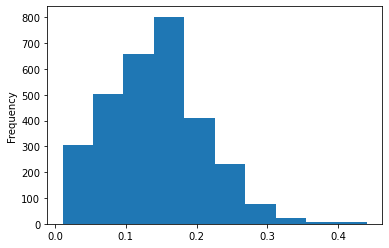

In [240]:
df_valid_noms['influencer_ratio_total'].plot.hist()

In [241]:
### PERCENTILE THRESHOLD 10% or 15% percentile cut-off (to link with previous literature)
# np.percentile(df_valid_noms['influencer_ratio_total'], 85),np.percentile(df_valid_noms['influencer_ratio_total'], 90),np.percentile(df_valid_noms['influencer_ratio_total'], 95)
# df_valid_noms[df_valid_noms['influencer_ratio_total']>=0.25]['Nominee'].nunique(),df_valid_noms[df_valid_noms['influencer_ratio_total']>=0.23]['Nominee'].nunique(),df_valid_noms[df_valid_noms['influencer_ratio_total']>=0.21]['Nominee'].nunique()
# df_valid_noms['isInfluencer'] = np.select([df_valid_noms['influencer_ratio_total']>=0.23],[1])

In [269]:
df_final = df_valid_noms.groupby(['Nominee','influencer_ratio_total','Nominee_id_Class_Y1','total_nominations'])['influencer_ratio_total'].count().reset_index(name='Waves')
df_final

,Nominee,influencer_ratio_total,Nominee_id_Class_Y1,total_nominations,Waves
0,1046,0.083333,59.0,20,4
1,1047,0.108333,59.0,26,4
2,1049,0.070833,59.0,17,4
3,1050,0.087500,59.0,21,4
4,1055,0.094444,59.0,17,3
...,...,...,...,...,...
639,4889,0.159722,131.0,61,4
640,4890,0.101190,131.0,37,4
641,6135,0.182540,131.0,46,3
642,6137,0.111111,131.0,28,3


##### Percentage Threshold - label 10% of highest influencer_Ratio as influencers

In [311]:
num_desired_influencers = math.floor(df_final['Nominee'].nunique()/10)
num_desired_influencers

64

In [312]:
lst_influencers = df_final.nlargest(num_desired_influencers,'influencer_ratio_total')['Nominee'].unique()
len(lst_influencers)

64

In [275]:
df_final['isInfluencer'] = np.select([df_final.Nominee.isin(lst_influencers)],[1])

In [277]:
len(df_final[df_final.isInfluencer == 1]['Nominee'].unique())

64

#### How many classes are with detected influencers and how many not?

##### note that this is not really accurate, as we take class y1 as reference (and classes can be changed) and we are looking at total_influencer (which is a combination of all 3 years)

In [300]:
df_final[df_final.isInfluencer == 1]['Nominee_id_Class_Y1'].nunique()/df_final['Nominee_id_Class_Y1'].nunique()*100

40.42553191489361

##### For complete accuracy, we need to generate influencers per wave, do we want this only for analysis purpose?

#### What if we look at the absolute number of nominations instead of a ratio? Are different influencers selected?

<AxesSubplot:ylabel='Frequency'>

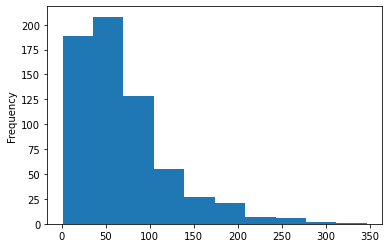

In [286]:
df_final['total_nominations'].plot.hist()

In [313]:
df_final.nlargest(num_desired_influencers,'total_nominations')

,Nominee,influencer_ratio_total,Nominee_id_Class_Y1,total_nominations,Waves,isInfluencer
210,1606,0.335606,81.0,347,7,1
227,1624,0.283193,81.0,300,7,1
407,2863,0.440476,124.0,286,7,1
230,1627,0.252786,81.0,266,7,1
226,1623,0.246687,81.0,263,7,1
212,1608,0.236717,81.0,257,7,1
220,1616,0.232612,81.0,247,7,1
231,1628,0.233770,81.0,244,7,1
416,2877,0.374687,124.0,244,7,1
221,1617,0.226997,81.0,237,7,1


In [314]:
lst_influencers_absolute_nominations = df_final.nlargest(num_desired_influencers,'total_nominations')['Nominee'].unique()
len(lst_influencers_absolute_nominations)

64

In [315]:
len(set(lst_influencers).intersection(set(lst_influencers_absolute_nominations)))

34

##### Around half of the influencers are different! (for GEN questions)

In [316]:
len(set(lst_influencers).intersection(set(lst_influencers_absolute_nominations)))/len(set(lst_influencers))*100

53.125

##### How many waves are the influencers participating in? / compared to non-influencers

<AxesSubplot:ylabel='Frequency'>

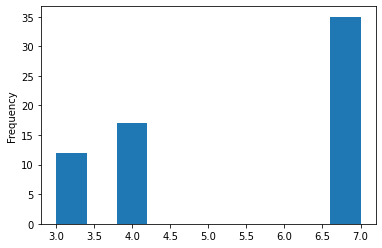

In [304]:
df_final[df_final.isInfluencer == 1]['Waves'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

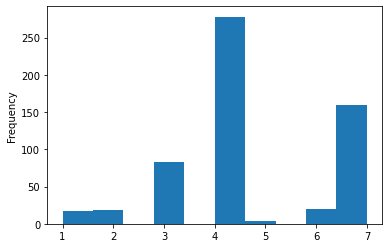

In [305]:
df_final[df_final.isInfluencer == 0]['Waves'].plot.hist()

In [296]:
### just to check how many of the ids are found among waves
# len(set(df_valid_noms[df_valid_noms.Wave == 1]['Nominee']).intersection(df_valid_noms[df_valid_noms.Wave == 2]['Nominee']))
# len(set(df_valid_noms[df_valid_noms.Wave == 1]['Nominee']).intersection(df_valid_noms[df_valid_noms.Wave == 3]['Nominee']))
# len(set(df_valid_noms[df_valid_noms.Wave == 1]['Nominee']).intersection(df_valid_noms[df_valid_noms.Wave == 4]['Nominee']))
# len(set(df_valid_noms[df_valid_noms.Wave == 1]['Nominee']).intersection(df_valid_noms[df_valid_noms.Wave == 5]['Nominee']))
# len(set(df_valid_noms[df_valid_noms.Wave == 1]['Nominee']).intersection(df_valid_noms[df_valid_noms.Wave == 6]['Nominee']))
# len(set(df_valid_noms[df_valid_noms.Wave == 1]['Nominee']).intersection(df_valid_noms[df_valid_noms.Wave == 7]['Nominee']))

### Extra: Influencers Per Wave

In [362]:
# class y2 and y3 are missing
df_valid_noms['Nominee_id_Class_Y2'] = df_valid_noms['Nominee'].map(df_pp.set_index('Child')['Class_Y2'])
df_valid_noms['Nominee_id_Class_Y3'] = df_valid_noms['Nominee'].map(df_pp.set_index('Child')['Class_Y3'])
df_valid_noms

,Nominee,Wave,questions_per_wave,Nominee_size_class,Nominee_id_Class_Y1,nominations_per_wave,total_nominations,influencer_ratio_wave,influencer_ratio_total,Nominee_id_Class_Y2,Nominee_id_Class_Y3
0,1046,1,6,10.0,59.0,7,20,0.116667,0.083333,59.0,311.0
1,1046,2,6,10.0,59.0,4,20,0.066667,0.083333,59.0,311.0
2,1046,3,6,10.0,59.0,4,20,0.066667,0.083333,59.0,311.0
3,1046,4,6,10.0,59.0,5,20,0.083333,0.083333,59.0,311.0
4,1047,1,6,10.0,59.0,12,26,0.200000,0.108333,59.0,311.0
...,...,...,...,...,...,...,...,...,...,...,...
3018,6137,6,4,21.0,131.0,7,28,0.083333,0.111111,131.0,131.0
3019,6137,7,4,21.0,131.0,4,28,0.047619,0.111111,131.0,131.0
3020,6138,5,4,21.0,131.0,28,78,0.333333,0.309524,131.0,131.0
3021,6138,6,4,21.0,131.0,29,78,0.345238,0.309524,131.0,131.0


In [363]:
df_list = list()
df_list.append(df_valid_noms[df_valid_noms.Wave == 1])
df_list.append(df_valid_noms[df_valid_noms.Wave == 2])
df_list.append(df_valid_noms[df_valid_noms.Wave == 3])
df_list.append(df_valid_noms[df_valid_noms.Wave == 4])
df_list.append(df_valid_noms[df_valid_noms.Wave == 5])
df_list.append(df_valid_noms[df_valid_noms.Wave == 6])
df_list.append(df_valid_noms[df_valid_noms.Wave == 7])

In [390]:
counter = 1 
list_influencers_per_wave = list()
for dff in df_list:
    print('Wave ' + str(counter))
    
    num_desired_influencers_df = math.floor(dff['Nominee'].nunique()/10)
    print('Number influencers: ', num_desired_influencers_df)
    
    lst_influencers_df = dff.nlargest(num_desired_influencers_df,'influencer_ratio_wave')['Nominee'].unique()
    list_influencers_per_wave.append(lst_influencers_df)
    
    dff['isInfluencer'] = np.select([dff['Nominee'].isin(lst_influencers_df)],[1])
    if(counter == 1 or counter == 2 or counter == 3):
        print('Percentage Class ' + str(dff[dff.isInfluencer == 1]['Nominee_id_Class_Y1'].nunique()/dff['Nominee_id_Class_Y1'].nunique()*100))
    elif(counter == 4):
        print('Percentage Class ' + str(dff[dff.isInfluencer == 1]['Nominee_id_Class_Y2'].nunique()/dff['Nominee_id_Class_Y2'].nunique()*100))
    else:
        print('Percentage Class ' + str(dff[dff.isInfluencer == 1]['Nominee_id_Class_Y3'].nunique()/dff['Nominee_id_Class_Y3'].nunique()*100))
    counter = counter + 1
    print('\n')


Wave 1
Number influencers:  60
Percentage Class 39.53488372093023


Wave 2
Number influencers:  61
Percentage Class 48.837209302325576


Wave 3
Number influencers:  59
Percentage Class 46.51162790697674


Wave 4
Number influencers:  53
Percentage Class 30.76923076923077


Wave 5
Number influencers:  23
Percentage Class 53.84615384615385


Wave 6
Number influencers:  22
Percentage Class 46.15384615384615


Wave 7
Number influencers:  21
Percentage Class 30.76923076923077




/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_89965/3120759989.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['isInfluencer'] = np.select([dff['Nominee'].isin(lst_influencers_df)],[1])
/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_89965/3120759989.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['isInfluencer'] = np.select([dff['Nominee'].isin(lst_influencers_df)],[1])
/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_89965/3120759989.py:12: SettingWithCo

#### What is the overlap between influencers among the waves? (len A, len Bintersection AB, difference AB, difference BA)

In [375]:
len(set(list_influencers_per_wave[0])),len(set(list_influencers_per_wave[1])),len(set(list_influencers_per_wave[0]).intersection(set(list_influencers_per_wave[1]))),len(set(list_influencers_per_wave[0]).difference(set(list_influencers_per_wave[1]))),len(set(list_influencers_per_wave[1]).difference(set(list_influencers_per_wave[0])))

(60, 61, 28, 32, 33)

In [376]:
len(set(list_influencers_per_wave[0])),len(set(list_influencers_per_wave[2])),len(set(list_influencers_per_wave[0]).intersection(set(list_influencers_per_wave[2]))),len(set(list_influencers_per_wave[0]).difference(set(list_influencers_per_wave[2]))),len(set(list_influencers_per_wave[2]).difference(set(list_influencers_per_wave[0])))

(60, 59, 27, 33, 32)

In [377]:
len(set(list_influencers_per_wave[0])),len(set(list_influencers_per_wave[3])),len(set(list_influencers_per_wave[0]).intersection(set(list_influencers_per_wave[3]))),len(set(list_influencers_per_wave[0]).difference(set(list_influencers_per_wave[3]))),len(set(list_influencers_per_wave[3]).difference(set(list_influencers_per_wave[0])))

(60, 53, 16, 44, 37)

In [378]:
len(set(list_influencers_per_wave[0])),len(set(list_influencers_per_wave[4])),len(set(list_influencers_per_wave[0]).intersection(set(list_influencers_per_wave[4]))),len(set(list_influencers_per_wave[0]).difference(set(list_influencers_per_wave[4]))),len(set(list_influencers_per_wave[4]).difference(set(list_influencers_per_wave[0])))

(60, 23, 7, 53, 16)

In [379]:
len(set(list_influencers_per_wave[0])),len(set(list_influencers_per_wave[5])),len(set(list_influencers_per_wave[0]).intersection(set(list_influencers_per_wave[5]))),len(set(list_influencers_per_wave[0]).difference(set(list_influencers_per_wave[5]))),len(set(list_influencers_per_wave[5]).difference(set(list_influencers_per_wave[0])))

(60, 22, 5, 55, 17)

In [380]:
len(set(list_influencers_per_wave[0])),len(set(list_influencers_per_wave[6])),len(set(list_influencers_per_wave[0]).intersection(set(list_influencers_per_wave[6]))),len(set(list_influencers_per_wave[0]).difference(set(list_influencers_per_wave[6]))),len(set(list_influencers_per_wave[6]).difference(set(list_influencers_per_wave[0])))

(60, 21, 3, 57, 18)